# Version 1 (naive)


    Description of function mandel()
    mandel function takes some variables "(x, y, max_iters
    c equal to the coordinate of the box,initial conditions for z = 0
    "for" loop- it runs from i = 1 to i = max_iters
    if condition tests if the magnitude is larger than 2
    it will return the number of iterations it took before z became > 2
    

    Description of create fractal()
    It loops across all the image pixels
    And calls mandel()
    Every single pixel gets a numerical value of iteration i
    the point image[y,x] gets colored based of this value
    Lastly, the numpy array image will be stored in hdf5 file
    


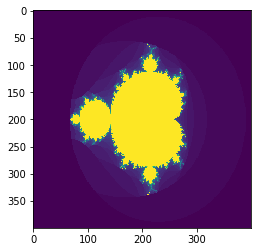

In [42]:
import numpy as np
from pylab import imshow, show
import matplotlib.pyplot as plt
import h5py
import line_profiler
profile = line_profiler.LineProfiler()
# this variable sets how many iterations we perform
max_iters = 50


def mandel(x, y, max_iters):
    """
    Description of function mandel()
    mandel function takes some variables "(x, y, max_iters
    c equal to the coordinate of the box,initial conditions for z = 0
    "for" loop- it runs from i = 1 to i = max_iters
    if condition tests if the magnitude is larger than 2
    it will return the number of iterations it took before z became > 2
    """
    c, z = complex(x, y), 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 2:
            return i
    return max_iters

# @profile


def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    """
    Description of create fractal()
    It loops across all the image pixels
    And calls mandel()
    Every single pixel gets a numerical value of iteration i
    the point image[y,x] gets colored based of this value
    Lastly, the numpy array image will be stored in hdf5 file
    """
    height, width = image.shape[0], image.shape[1]
    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    for x in range(width):
        real = min_x + x * pixel_size_x
        for y in range(height):
            imag = min_y + y * pixel_size_y
            color = mandel(real, imag, iters)
            image[y, x] = color
    with h5py.File('naiveVersion.hdf5', 'w') as hdf:
        hdf.create_dataset('dataset_1', data=image)

# this generates the image the data will be saved to
image = np.zeros((400, 400), dtype=np.uint8)
# this calls the main function and gives c mesh limits
create_fractal(-2, 1.5, -1.5, 1.5, image, max_iters)
print(mandel.__doc__)
print(create_fractal.__doc__)
imshow(image)  # this plots the image
plt.savefig('version1.png', dpi=300, bbox_inches='tight')
show()


# Profiling and benchmarking

In [44]:
profile.print_stats()

Timer unit: 1e-06 s

Total time: 35.1547 s
File: <ipython-input-43-f561127e7c72>
Function: create_fractal at line 55

Line #      Hits         Time  Per Hit   % Time  Line Contents
    55                                           @profile
    56                                           def create_fractal(min_x, max_x, min_y, max_y, image, iters):
    57                                           
    58         1         10.0     10.0      0.0    height,width  = image.shape[0],image.shape[1]
    59                                             
    60                                             
    61         1          5.0      5.0      0.0    pixel_size_x,pixel_size_y = (max_x - min_x) / width ,(max_y - min_y) / height
    62                                               
    63                                               
    64      1001       2133.0      2.1      0.0    for x in range(width):            # loops through all the points in a row
    65      1000       2774.0      2.

In [11]:
%timeit create_fractal(-2, 1.5, -1.5, 1.5, image, max_iters)

1.87 s ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Test

In [8]:
def mandel(x, y, max_iters):
    ''' 
    This function calculates recursively and 
    returns the mandelbrot of a positive number. 
    Define input and expected output: 
    >>> mandel(0,0,10) 
    10
    >>> mandel(1,1,10)  
    0
    >>> mandel(0.5,-0.5,10) 
    2
    >>> mandel(-0.5,0.5,10) 
    10
    >>> mandel(-1,-1,10) 
    0
    ''' 
    c,z = complex(x, y),0.0j   
    for i in range(max_iters):  
      z = z*z + c
      if (z.real*z.real + z.imag*z.imag) >= 2:
          return i    
    return max_iters

def _test():
    import doctest 
    doctest.testmod(verbose=True)
    
if __name__== '__main__':
    _test()
    

Trying:
    mandel(0,0,10) 
Expecting:
    10
ok
Trying:
    mandel(1,1,10)  
Expecting:
    0
ok
Trying:
    mandel(0.5,-0.5,10) 
Expecting:
    2
ok
Trying:
    mandel(-0.5,0.5,10) 
Expecting:
    10
ok
Trying:
    mandel(-1,-1,10) 
Expecting:
    0
ok
2 items had no tests:
    __main__
    __main__._test
1 items passed all tests:
   5 tests in __main__.mandel
5 tests in 3 items.
5 passed and 0 failed.
Test passed.


# Version 2 (Vectorised Numpy)

In [37]:
# code before optimization
import numpy as np
import h5py
from imageio import imwrite
from PIL import Image
import time

max_iters = 50  # max iterations
width = 400  # dimension used for height and width
height = 400
min_x = -2
max_x = 1.5
min_y = -2.0
max_y = 1.0
pixel_size_x = (max_x - min_x) / width
pixel_size_y = (max_y - min_y) / height


def create_fractal():
    """
    This code is before code optimization
    Description of function create_fractal()
    In this version numpy vectorization is used
    It translates the vector and matrix operations x,y
    Then it returns mesh grid starting with based on parameters
    x min, x max, y min, ymax and the x and y incremental values
    which are respectively x and y pixel sizes
    It iterates accross the image matrix
    each pixels values with a magnitude larger than 2
    will escape and cannot be part of the set thus it's value will set
    to be false
    finally using imagio library the matrix image will be colored
    based on the value of each pixel which is either true = white
    or false = black (not a part of mandel)
    """
    # initial z and c values
    z = np.zeros((width, height), dtype=np.complex)
    # take x and y values and return a mesh grid
    x, y = np.mgrid[min_x:max_x:pixel_size_x, min_y:max_y:pixel_size_y]
    c = y+1j*x
    # initialization image matrix with all entry =  true values
    image = np.full((width, height), True, dtype=bool)
    # do iterations and put the points that diverges = false
    for i in range(max_iters):
        z[image] = z[image]*z[image] + c[image]
        image[np.abs(z) >= 2] = False
    with h5py.File('VectorizedVersion.hdf5', 'w') as hdf:
        hdf.create_dataset('dataset_1', data=image)
    # give the image matrix color based on the entries values
    imwrite('version2.png', np.uint8(image*255))
    

create_fractal()
print(create_fractal.__doc__)
time.sleep(1) # just give the image 1 ms to be saved
im = Image.open("version2.png")
im.show()



    This code is before code optimization
    Description of function create_fractal()
    In this version numy vectorization is used
    It translates the vector and matrix operations x,y
    Then it returns mesh grid starting with based on parameters
    x min, x max, y min, ymax and the x and y incremental values
    which are respectively x and y pixel sizes
    It iterates accross the image matrix
    each pixels values with a magnitude larger than 2
    will escape and cannot be part of the set thus it's value will set
    to be false
    finally using imagio library the matrix image will be colored
    based on the value of each pixel which is either true = white
    or false = black (not a part of mandel)
    


In [38]:
%timeit create_fractal()

913 ms ± 34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
# code after optimization
import numpy as np
import h5py
from imageio import imwrite
from PIL import Image
import time

width = 400  # dimension used for height and width
height = 400

def create_fractal(min_x, max_x, min_y, max_y, image, max_iters):
    """
    This code is after code optimization
    Description of function create_fractal()
    In this version numy vectorization is used
    It translates the vector and matrix operations x,y
    Then it returns mesh grid starting with based on parameters
    x min, x max, y min, ymax and the x and y incremental values
    which are respectively x and y pixel sizes
    It iterates accross the image matrix
    each pixels values with a magnitude larger than 2
    will escape and cannot be part of the set thus it's value will set
    to be false
    finally using imagio library the matrix image will be colored
    based on the value of each pixel which is either true = white
    or false = black (not a part of mandel)
    """
    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    # initial z and c values
    z = np.zeros((width, height), dtype=np.complex)
    # take x and y values and return a mesh grid
    x, y = np.mgrid[min_x:max_x:pixel_size_x, min_y:max_y:pixel_size_y]
    c = y+1j*x
    # do iterations and put the points that diverges = false
    for i in range(max_iters):
        z[image] = z[image]*z[image] + c[image]
        #print(z[image][1600])
        #print(c[image])
        image[np.abs(z) >= 2] = False
    # with h5py.File('VectorizedVersion.hdf5', 'w') as hdf:
        # hdf.create_dataset('dataset_1', data=image)
    # give the image matrix color based on the entries values
    imwrite('version2.png', np.uint8(image*255))

# initialization image matrix with all entry =  true values
image = np.full((width, height), True, dtype=bool)
create_fractal(-1.5, 1.5, -2.0, 1.0, image, 50)
print(create_fractal.__doc__)
time.sleep(1) # just give the image 1 ms to be saved
im = Image.open("version2.png")
im.show()



    This code is after code optimization
    Description of function create_fractal()
    In this version numy vectorization is used
    It translates the vector and matrix operations x,y
    Then it returns mesh grid starting with based on parameters
    x min, x max, y min, ymax and the x and y incremental values
    which are respectively x and y pixel sizes
    It iterates accross the image matrix
    each pixels values with a magnitude larger than 2
    will escape and cannot be part of the set thus it's value will set
    to be false
    finally using imagio library the matrix image will be colored
    based on the value of each pixel which is either true = white
    or false = black (not a part of mandel)
    


# Profiling and benchmarking

In [36]:
%timeit create_fractal(-1.5, 1.5, -2.0, 1.0, image, 80)

657 ms ± 9.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Test

In [7]:
import numpy as np
width = 3  # dimension used for height and width
height = 3


def create_fractal(min_x, max_x, min_y, max_y, image, max_iters):
    pixel_size_x = (max_x - min_x) / width
    pixel_size_y = (max_y - min_y) / height
    # initial z and c values
    z = np.zeros((width, height), dtype=np.complex)
    # take x and y values and return a mesh grid
    x, y = np.mgrid[min_x:max_x:pixel_size_x, min_y:max_y:pixel_size_y]
    c = y+1j*x
    # do iterations and put the points that diverges = false
    for i in range(max_iters):
        z[image] = z[image]*z[image] + c[image]
        image[np.abs(z) >= 2] = False
image = np.full((width, height), True, dtype=bool)
create_fractal(-1.5, 1.5, -2.0, 1.0, image, 3)


expected = [[False, False, False],
            [False,  True,  True],
            [False,  True,  True]]

def check_arrays(a,b):
    ''' 
    This function calculates recursively and 
    returns the mandelbrot of a positive number. 
    Define input and expected output: 
    >>> check_arrays(image,expected) 
    1
    '''
    if (a==b).all():
        return 1
    else:
        return 0

def _test():
    import doctest
    doctest.testmod(verbose=True)
    
if __name__== '__main__':
    _test()
    

Trying:
    check_arrays(image,expected) 
Expecting:
    1
ok
3 items had no tests:
    __main__
    __main__._test
    __main__.create_fractal
1 items passed all tests:
   1 tests in __main__.check_arrays
1 tests in 4 items.
1 passed and 0 failed.
Test passed.


# Version 3 (multiprocessing)


    Description of function mandelbrot()
    mandel function takes parameter z (complex)
    check values for each pixel
    "for" loop- it runs from i = 1 to i = max_iters
    if condition tests if the magnitude is larger than 2
    it will return the number of iterations it took before z became > 2
    

    Description of function create_fractal()
    The multiprocessing will create moultiprocessing pool with 4 processes
    Pool uses the function map() that call the function mandelbrot()
    to perform the computation on every single pixel
    check values for each pixel
    Using the multiprocessing will make it faster
    when the map() function calls mandelbrot()
    the work will be split up and distributed in parallel
    then the result will be collected in the list image
    Lastly the list image will be reshaped to be a matrix and
    then it will be build as an image using matplotlib library
    The image can be seen below
    


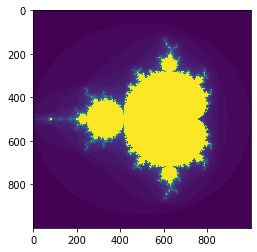

In [2]:
from multiprocessing import Pool
from numpy import linspace, reshape
from matplotlib import pyplot
import h5py
max_iters = 50  # max iterations


def mandelbrot(z):
    """
    Description of function mandelbrot()
    mandel function takes parameter z (complex)
    check values for each pixel
    "for" loop- it runs from i = 1 to i = max_iters
    if condition tests if the magnitude is larger than 2
    it will return the number of iterations it took before z became > 2
    """
    c = z
    for i in range(max_iters):
        z = z*z + c
        if abs(z) > 2:
            return i
    return max_iters


def create_fractal():
    """
    Description of function create_fractal()
    The multiprocessing will create moultiprocessing pool with 4 processes
    Pool uses the function map() that call the function mandelbrot()
    to perform the computation on every single pixel
    check values for each pixel
    Using the multiprocessing will make it faster
    when the map() function calls mandelbrot()
    the work will be split up and distributed in parallel
    then the result will be collected in the list image
    Lastly the list image will be reshaped to be a matrix and
    then it will be build as an image using matplotlib library
    The image can be seen below
    """
    xmin, xmax, ymin, ymax, width, height = -2.0, 1, -1.5, 1.5, 1000, 1000
    # Mesh limits
    X = linspace(xmin, xmax, width)
    Y = linspace(ymin, ymax, height)
    # creates a multi-process pool, with 4 processes
    p = Pool(4)
    Z = [complex(x, y) for y in Y for x in X]
    # map() makes calls to mandelbrot() by plitting up the work
    # and distributing it in parallel using the pool.
    image = p.map(mandelbrot, Z)
    # The results are collected back together into a single list image
    # change the shape of list to rectangular array
    image = reshape(image, (width, height))
    with h5py.File('multyVersion.hdf5', 'w') as hdf:
        hdf.create_dataset('dataset_1', data=image) #creating dataset using the file object hf
    print (mandelbrot.__doc__)
    print (create_fractal.__doc__)
    # plot the image
    pyplot.imshow(image)
    pyplot.savefig('multi.pdf', dpi=300, bbox_inches='tight')
    pyplot.show()

create_fractal()

    

# Profiling and benchmarking

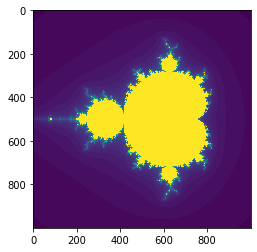

In [94]:
# this implementation is just for profiling 
from multiprocessing import Pool
from numpy           import linspace, reshape
from matplotlib      import pyplot
import h5py
import line_profiler
profile = line_profiler.LineProfiler()

max_iters =  50 # max iterations

def mandelbrot(z): # check values for each pixel
  c = z
  for i in range(max_iters):
    if abs(z)>2:return i  # return i if z diverges 
    z = z*z + c
     
  return max_iters         


@profile
def create_fractal():
    xmin,xmax,ymin,ymax,width,height = -2.0, 1, -1.5, 1.5 ,1000, 1000
    X = linspace(xmin,xmax,width) # lists of x and y
    Y = linspace(ymin,ymax,height) # pixel co-ordinates
    p = Pool(4) 
    Z = [complex(x,y) for y in Y for x in X]
    image = p.map(mandelbrot,Z) 
    image = reshape(image, (width,height))
    pyplot.imshow(image) 
    pyplot.show()

create_fractal()
    

In [95]:
profile.print_stats()

Timer unit: 1e-06 s

Total time: 16.6948 s
File: <ipython-input-94-4ca381444336>
Function: create_fractal at line 19

Line #      Hits         Time  Per Hit   % Time  Line Contents
    19                                           @profile
    20                                           def create_fractal():
    21         1          6.0      6.0      0.0      xmin,xmax,ymin,ymax,width,height = -2.0, 1, -1.5, 1.5 ,1000, 1000
    22         1       1183.0   1183.0      0.0      X = linspace(xmin,xmax,width) # lists of x and y
    23         1       2591.0   2591.0      0.0      Y = linspace(ymin,ymax,height) # pixel co-ordinates
    24         1     316171.0 316171.0      1.9      p = Pool(4) 
    25         1    2120352.0 2120352.0     12.7      Z = [complex(x,y) for y in Y for x in X]
    26         1   12488800.0 12488800.0     74.8      image = p.map(mandelbrot,Z) 
    27         1     512678.0 512678.0      3.1      image = reshape(image, (width,height))
    28         1     286473

# Test 

In [35]:
def mandelbrot(z,max_iters):
    ''' 
    This function calculates recursively and 
    returns the mandelbrot of a positive number. 
    Define input and expected output: 
    >>> mandelbrot(complex(0.7,-0.5),10)
    2
    >>> mandelbrot(complex(-0.7,-0.8),10)  
    3
    >>> mandelbrot(complex(1.2,0.5),10)
    1
    >>> mandelbrot(complex(1,-1.1),10) 
    1
    >>> mandelbrot(complex(-0.9,1.2),10) 
    2
    ''' 
    c = z
    for i in range(max_iters):
        if abs(z)>2:
            return i
        z = z*z + c
    return max_iters 

def _test():
    import doctest 
    doctest.testmod(verbose=True)
    
if __name__== '__main__':
    _test()
    

Trying:
    mandelbrot(complex(0.7,-0.5),10)
Expecting:
    2
ok
Trying:
    mandelbrot(complex(-0.7,-0.8),10)  
Expecting:
    3
ok
Trying:
    mandelbrot(complex(1.2,0.5),10)
Expecting:
    1
ok
Trying:
    mandelbrot(complex(1,-1.1),10) 
Expecting:
    1
ok
Trying:
    mandelbrot(complex(-0.9,1.2),10) 
Expecting:
    2
ok
2 items had no tests:
    __main__
    __main__._test
1 items passed all tests:
   5 tests in __main__.mandelbrot
5 tests in 3 items.
5 passed and 0 failed.
Test passed.
